# Generative Adversarial Networks: Generating Graphene EM Images

We have used the electron microscopy (EM) images of graphene to practice denoising by autoencoders in [06_autoencoder_practical.ipynb](06_autoencoder_practical.ipynb). In this notebook, we will use the clean EM images in the same dataset to train a GAN.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

Using TensorFlow v2.1.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    data_path = './sciml-workshop-data/'
    

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# The dataset


This part is the same as in [06_autoencoder_practical.ipynb](06_autoencoder_practical.ipynb).

### Open data file

In [4]:
# define image size
IMG_WIDTH = 64
IMG_HEIGHT = 64
N_CHANNELS = 1

# generator
def hdf_generator(path, buffer_size=128):
    """ Load data DMS data from disk
    
    Args:
        path: path of the HDF file on disk
        buffer_size: number of images to read from disk
    """
    with h5py.File(path, 'r') as handle:
        n_samples, h, w, c = handle['noisey'].shape
        for i in range(0, n_samples, buffer_size):
            noise = handle['noisey'][i:i+buffer_size]
            clean = handle['clean'][i:i+buffer_size]
            yield noise, clean

# dataset
dataset_file = tf.data.Dataset.from_generator(lambda: hdf_generator(path=data_path + '/em-data/train.h5'), 
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), 
                                                             (None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
print(dataset_file)

<FlatMapDataset shapes: ((None, 64, 64, 1), (None, 64, 64, 1)), types: (tf.float32, tf.float32)>


### Process dataset

In [13]:
# constants
BUFFER_SIZE = 200
BATCH_SIZE = 32

# unbatch
dataset = dataset_file.unbatch()

# shuffle
dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)

# normalize to [-1, 1]
def normalize(X, Y):
    X = 2 * (X - tf.reduce_min(X)) / (tf.math.reduce_max(X) - tf.math.reduce_min(X)) - 1
    Y = 2 * (Y - tf.reduce_min(Y)) / (tf.math.reduce_max(Y) - tf.math.reduce_min(Y)) - 1
    return X, Y
dataset = dataset.map(normalize)

# re-batch
dataset = dataset.batch(BATCH_SIZE)

### Plot examples

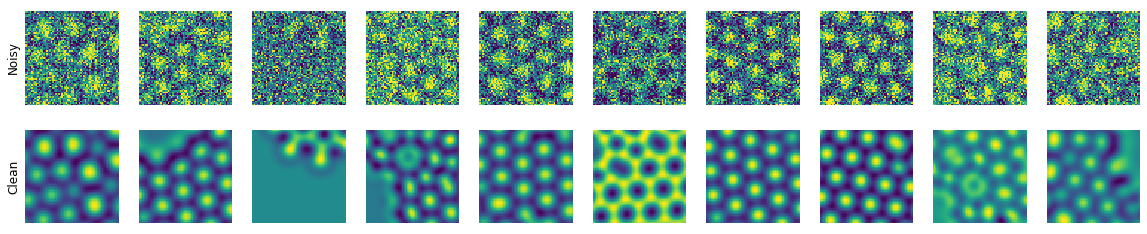

In [6]:
# take the first buffer
noisy, clean = list(dataset.take(1))[0]

# plot 10 pairs
nplot = 10
fig, axes = plt.subplots(2, nplot, figsize=(nplot * 2, 4))
for ax, img_noise, img_clean in zip(axes.T, noisy[:nplot], clean[:nplot]):
    ax[0].matshow(np.squeeze(img_noise))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].matshow(np.squeeze(img_clean))
    ax[1].set_xticks([])
    ax[1].set_yticks([])   
axes[0, 0].set_ylabel('Noisy', c='k')
axes[1, 0].set_ylabel('Clean', c='k')
plt.show()

---

# Create a GAN

### The generator

Create a generator network. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb), only changing the image size.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
def make_generator_model(noise_size=100, image_size=(28,28), n_filters=(256,128,64)):
    '''
    Create a generator, hardcoded with three Conv2DTranspose layers.
    
    :param noise_size: size of the seed vector
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the generator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Dense
    # input shape: (100,)
    # output shape: (7*7*256,)
    w = image_size[0] // 4
    h = image_size[1] // 4
    model.add(layers.Dense(w*h*n_filters[0], use_bias=False, 
                           input_shape=(noise_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape
    # input shape: (7*7*256,)
    # output shape: (7, 7, 256)
    model.add(layers.Reshape((w, h, n_filters[0])))

    # Conv2DTranspose
    # input shape: (7, 7, 256)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2DTranspose(n_filters[1], (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (7, 7, 128)
    # output shape: (14, 14, 64)
    model.add(layers.Conv2DTranspose(n_filters[2], (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (14, 14, 64)
    # output shape: (28, 28, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, activation='tanh'))
    
    # input: (100,)
    # output: (28, 28, 1)
    return model

# noise size
NOISE_SIZE = 100

# create a generator
generator = make_generator_model(noise_size=NOISE_SIZE, image_size=(64,64), n_filters=(256,128,64))
```
    
</p>
</details>


In [7]:
def make_generator_model(noise_size=100, image_size=(28,28), n_filters=(256,128,64)):
    '''
    Create a generator, hardcoded with three Conv2DTranspose layers.
    
    :param noise_size: size of the seed vector
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the generator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Dense
    # input shape: (100,)
    # output shape: (7*7*256,)
    w = image_size[0] // 4
    h = image_size[1] // 4
    model.add(layers.Dense(w*h*n_filters[0], use_bias=False, 
                           input_shape=(noise_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape
    # input shape: (7*7*256,)
    # output shape: (7, 7, 256)
    model.add(layers.Reshape((w, h, n_filters[0])))

    # Conv2DTranspose
    # input shape: (7, 7, 256)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2DTranspose(n_filters[1], (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (7, 7, 128)
    # output shape: (14, 14, 64)
    model.add(layers.Conv2DTranspose(n_filters[2], (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (14, 14, 64)
    # output shape: (28, 28, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, activation='tanh'))
    
    # input: (100,)
    # output: (28, 28, 1)
    return model

# noise size
NOISE_SIZE = 100

# create a generator
generator = make_generator_model(noise_size=NOISE_SIZE, image_size=(64,64), n_filters=(256,128,64))

### The discriminator

Create a generator network. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb), only changing the image size.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
def make_discriminator_model(image_size=(28,28), n_filters=(64,128)):
    '''
    Create a discriminator, hardcoded with two Conv2D layers.
    
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the discriminator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Conv2D
    # input shape: (28, 28, 1)
    # output shape: (14, 14, 64)
    w = image_size[0]
    h = image_size[1]
    model.add(layers.Conv2D(n_filters[0], (5, 5), strides=(2, 2), padding='same',
              input_shape=[w, h, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Conv2D
    # input shape: (14, 14, 64)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2D(n_filters[1], (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten
    # input shape: (7, 7, 128)
    # output shape: (7*7*128,)
    model.add(layers.Flatten())
    
    # 4th layer: Dense
    # input shape: (7*7*128,)
    # output shape: (1,)
    model.add(layers.Dense(1))
    
    # input: (28, 28, 1)
    # output: (1,)
    return model

# create a discriminator
discriminator = make_discriminator_model(image_size=(64,64), n_filters=(64,128))
```
    
</p>
</details>

In [8]:
def make_discriminator_model(image_size=(28,28), n_filters=(64,128)):
    '''
    Create a discriminator, hardcoded with two Conv2D layers.
    
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the discriminator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Conv2D
    # input shape: (28, 28, 1)
    # output shape: (14, 14, 64)
    w = image_size[0]
    h = image_size[1]
    model.add(layers.Conv2D(n_filters[0], (5, 5), strides=(2, 2), padding='same',
              input_shape=[w, h, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Conv2D
    # input shape: (14, 14, 64)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2D(n_filters[1], (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten
    # input shape: (7, 7, 128)
    # output shape: (7*7*128,)
    model.add(layers.Flatten())
    
    # 4th layer: Dense
    # input shape: (7*7*128,)
    # output shape: (1,)
    model.add(layers.Dense(1))
    
    # input: (28, 28, 1)
    # output: (1,)
    return model

# create a discriminator
discriminator = make_discriminator_model(image_size=(64,64), n_filters=(64,128))

### Loss functions and optimizers

Create the loss functions and optimizers for the generator and discriminator. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb) without changing anything.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# cross entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator's loss 
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator's loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
```
    
</p>
</details>

In [9]:
# cross entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator's loss 
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator's loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

---

# Training Loop

Implement the training function for a batch. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb) without changing anything.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# this function is called for each batch
def train_step(real_images, batch_size, noise_size):
    # seed
    seed = tf.random.normal([batch_size, noise_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # fake images
        fake_images = generator(seed, training=True)
        
        # discriminate real
        real_score = discriminator(real_images, training=True)
        # discriminate fake
        fake_score = discriminator(fake_images, training=True)

        # compute losses
        gen_loss = generator_loss(fake_score)
        disc_loss = discriminator_loss(real_score, fake_score)
        
        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # apply gradients to update model parameters
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
        
        return gen_loss, disc_loss
```
    
</p>
</details>


In [10]:
# this function is called for each batch
def train_step(real_images, batch_size, noise_size):
    # seed
    seed = tf.random.normal([batch_size, noise_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # fake images
        fake_images = generator(seed, training=True)

        # discriminate real
        real_score = discriminator(real_images, training=True)
        # discriminate fake
        fake_score = discriminator(fake_images, training=True)

        # compute losses
        gen_loss = generator_loss(fake_score)
        disc_loss = discriminator_loss(real_score, fake_score)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # apply gradients to update model parameters
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        return gen_loss, disc_loss

Now perform the training. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb), only changing the epochs and the data reading line.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
############################
######### TRAINING #########
############################

# epochs
EPOCHS = 50

# epoch loop
tstart = time.time()
for epoch in range(EPOCHS):
    # shuffle before each epoch
    dataset = dataset.shuffle(BUFFER_SIZE)
    # batch loop
    for i, (noisy_batch, clean_batch) in enumerate(dataset):
        gen_loss, disc_loss = train_step(clean_batch, BATCH_SIZE, NOISE_SIZE)
    # print loss after each epoch
    print(f'Epoch {epoch + 1} / {EPOCHS}, Elapsed = {time.time() - tstart:.2f} s, '
          f'Gen loss = {gen_loss:.2f}, Disc loss = {disc_loss:.2f}')
```
    
</p>
</details>

In [11]:
############################
######### TRAINING #########
############################

# epochs
EPOCHS = 50

# epoch loop
tstart = time.time()
for epoch in range(EPOCHS):
    # batch loop
    for i, (noisy_batch, clean_batch) in enumerate(dataset):
        gen_loss, disc_loss = train_step(clean_batch, BATCH_SIZE, NOISE_SIZE)
    # print loss after each epoch
    print(f'Epoch {epoch + 1} / {EPOCHS}, Elapsed = {time.time() - tstart:.2f} s, '
          f'Gen loss = {gen_loss:.2f}, Disc loss = {disc_loss:.2f}')

Epoch 1 / 50, Elapsed = 6.23 s, Gen loss = 0.64, Disc loss = 1.38
Epoch 2 / 50, Elapsed = 12.21 s, Gen loss = 0.59, Disc loss = 1.40
Epoch 3 / 50, Elapsed = 18.38 s, Gen loss = 0.74, Disc loss = 1.18
Epoch 4 / 50, Elapsed = 24.20 s, Gen loss = 0.81, Disc loss = 1.11
Epoch 5 / 50, Elapsed = 30.18 s, Gen loss = 0.57, Disc loss = 1.36
Epoch 6 / 50, Elapsed = 36.28 s, Gen loss = 0.48, Disc loss = 1.54
Epoch 7 / 50, Elapsed = 42.33 s, Gen loss = 1.12, Disc loss = 1.07
Epoch 8 / 50, Elapsed = 48.18 s, Gen loss = 1.39, Disc loss = 0.96
Epoch 9 / 50, Elapsed = 53.69 s, Gen loss = 1.18, Disc loss = 0.83
Epoch 10 / 50, Elapsed = 60.27 s, Gen loss = 1.55, Disc loss = 0.61
Epoch 11 / 50, Elapsed = 66.50 s, Gen loss = 1.65, Disc loss = 0.61
Epoch 12 / 50, Elapsed = 73.42 s, Gen loss = 2.72, Disc loss = 0.42
Epoch 13 / 50, Elapsed = 79.62 s, Gen loss = 3.98, Disc loss = 0.33
Epoch 14 / 50, Elapsed = 86.33 s, Gen loss = 4.10, Disc loss = 0.26
Epoch 15 / 50, Elapsed = 93.19 s, Gen loss = 4.35, Disc lo

Finally, use the trained generator to generate images from random noise. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb) without changing anything.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# seed
seed = tf.random.normal([1, NOISE_SIZE])

# generate and plot the image
generated_image = generator(seed, training=False)
plt.figure(dpi=100)
plt.imshow(generated_image[0, :, :, 0])
plt.axis('off')
plt.show()
```
    
</p>
</details>

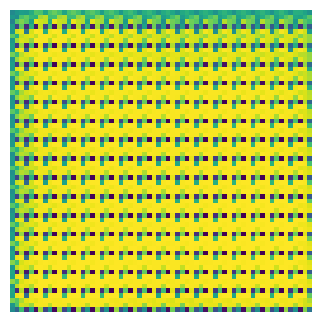

In [12]:
# seed
seed = tf.random.normal([1, NOISE_SIZE])

# generate and plot the image
generated_image = generator(seed, training=False)
plt.figure(dpi=100)
plt.imshow(generated_image[0, :, :, 0])
plt.axis('off')
plt.show()